Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
20241025<br><br>
PyGEM MCMC regional calibration analysis


The main objective of this notebook is to assess the performance of MCMC calibration method for all glaciers in Alaska. The analysis in this notebook assumes that three MCMC chains have been run for each glacier in Alaska, which we'll now assess.

If the calibration has not yet been completed, first run 3 MCMC calibration chains - note, check option_use_emulator under the MCMC_params in ~/PyGEM/config.yaml.  If option_use_emulator is true, the calibration procedure must first have been completed with option_calibration=emulator.  Steps detailed below:


1. run_calibration -rgi_region01 1 -option_calibration emulator
2. run_calibration -rgi_region01 1 -option_calibration MCMC (ensure n_chains is set to `3` in  ~/PyGEM/config.yaml)

Note, here we've subset to run only glaciers with area > 1 sq km to speed up processing.

In [1]:
import os, pickle, glob, copy, sys, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde, norm, gamma, truncnorm
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import arviz as az
import xarray as xr
from IPython.display import display, HTML, Image
import matplotlib.image as mpimg
import cmocean
# pygem imports
import pygem
import pygem.setup.config as config
# check for config
config.ensure_config()
# read the config
pygem_prms = config.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                    # the appropriate location. If any errors occur, check this first.
import pygem.pygem_modelsetup as modelsetup
from pygem import mcmc
from pygem.shop import oib

plt.rcParams["font.family"] = "arial"
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 6

In [2]:
# define output calibration path
datpath = pygem_prms['root']+'/Output/calibration/01/'

In [3]:
# get rgi table for all glaciers in region
rgi_glacs = modelsetup.selectglaciersrgitable(rgi_regionsO1=[1])

This study is focusing on 27108 glaciers in region [1]


In [ ]:
# loop through each glacier modelprm_dict and get some stats
chain_ns = [0,1,2]

# keys (variables) of interest
ks = ['kp','tbias','ddfsnow','ddfice','mb_mwea']

# Define the list of functions
stats = [
    lambda x: float(np.median(x)),
    lambda x: float(np.mean(x)),
    lambda x: float(np.std(x)),
    lambda x: float(np.percentile(x, 75) - np.percentile(x, 25)), 
    pygem.mcmc.effective_n
    ]
# associated keys to use for each stat
stats_ks = ['median','mean','std','iqr','n_eff']

# create master mcmc_stats dictionary
mcmc_stats = {}
for f in sorted(glob.glob(datpath + '/*-modelprms_dict.json')):
    try:
        reg, glacno = f.split('/')[-1].split('.')[:2]
        glacno = reg + '.' + glacno[:5]
        
        with open(f,'rb') as fin:
            prms_dict = json.load(fin)['MCMC']
            # create deep copy of dictionary
            prms_dict_stats = copy.deepcopy(prms_dict)

            # loop over variables
            for k in ks:
                # go through each chain and calculate some stats on each chain for each variable
                for n in chain_ns:
                    prms_dict_stats[k][f'chain_{n}'] = {}
                    for i, s in enumerate(stats_ks):
                        prms_dict_stats[k][f'chain_{n}'][s] = stats[i](prms_dict[k][f'chain_{n}'])

                # also calculate the gelman-rubins stat for each variable across all chains
                # stack chains into a single 2d array
                chains = np.array([prms_dict[k][f'chain_{n}'] for n in chain_ns])
                # convert the chains into an InferenceData object
                idata = az.from_dict(posterior={k: chains})
                # calculate the Gelman-Rubin statistic
                prms_dict_stats[k]['rhat'] = float(az.rhat(idata).to_array().values[0])

            # perform some stats on the acceptance rate
            prms_dict_stats['ar'] = {}
            for n in chain_ns:
                prms_dict_stats['ar'][f'chain_{n}'] = {}
                rolling_ar = np.convolve(np.array(prms_dict['ar'][f'chain_{n}']), np.ones(100)/100, mode='valid')
                for i, s in enumerate(stats_ks[:-2]):
                    prms_dict_stats['ar'][f'chain_{n}'][s] = stats[i](rolling_ar)

        # get glacier size
        prms_dict_stats['area'] = float(rgi_glacs.loc[rgi_glacs['glacno'] == glacno, 'Area'].iloc[0])

        mcmc_stats[glacno] = prms_dict_stats
    except Exception as err:
        print(err)

In [ ]:
mcmc_stats

{'1.00003': {'tbias': {'chain_0': {'median': -0.21335820864865737,
    'mean': -0.16531453723852801,
    'std': 1.1828860483107184,
    'iqr': 1.6810564493819296,
    'n_eff': 231},
   'chain_1': {'median': -0.44052155884464367,
    'mean': -0.31500868463849746,
    'std': 1.1744849576554113,
    'iqr': 1.575621559830675,
    'n_eff': 240},
   'chain_2': {'median': -0.25930323478298917,
    'mean': -0.19866054824363918,
    'std': 1.2343178737902023,
    'iqr': 1.7125301856548143,
    'n_eff': 257},
   'rhat': 1.0044451952171534},
  'kp': {'chain_0': {'median': 1.6042319688465296,
    'mean': 1.742536342181182,
    'std': 0.8340543622298291,
    'iqr': 1.1243867815737336,
    'n_eff': 151},
   'chain_1': {'median': 1.5317751662008594,
    'mean': 1.6729244131566665,
    'std': 0.8333783715721346,
    'iqr': 1.100293913248809,
    'n_eff': 202},
   'chain_2': {'median': 1.6745637958315007,
    'mean': 1.7928045362335319,
    'std': 0.8440721159980515,
    'iqr': 1.1465996498448203,
    

In [ ]:
lg_mcmc_stats = copy.deepcopy(mcmc_stats)
areas=[]
for g in list(mcmc_stats.keys()):
    if mcmc_stats[g]['area'] < 1:
        del lg_mcmc_stats[g]

In [ ]:
lg_mcmc_stats[g][k]

{'chain_0': {'median': -0.1643359138314151,
  'mean': -0.16237075762105274,
  'std': 0.1675912094552866,
  'iqr': 0.22416681808702033,
  'n_eff': 1414},
 'chain_1': {'median': -0.16995114789148014,
  'mean': -0.16503079718582075,
  'std': 0.16401585293013926,
  'iqr': 0.23377708467554947,
  'n_eff': 1412},
 'chain_2': {'median': -0.17715151887241753,
  'mean': -0.17006472971550857,
  'std': 0.16690482703184356,
  'iqr': 0.2170974627021075,
  'n_eff': 1148},
 'rhat': 1.0000324231229079}

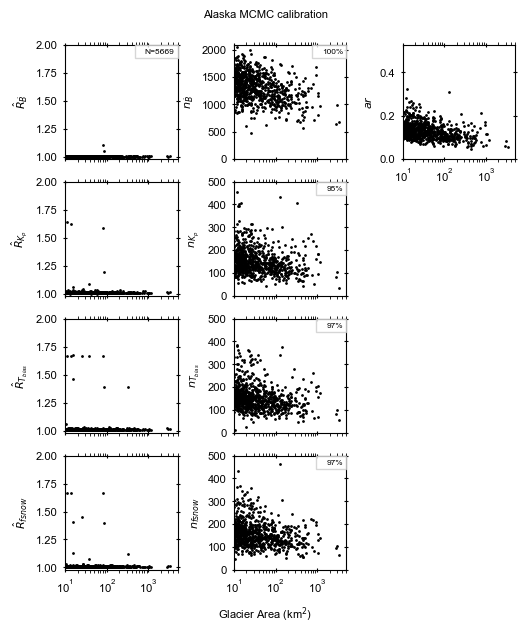

In [ ]:
# plot GR and averge n_eff stats by glacier area
s=1
fig = plt.figure(figsize=(5,6))
gs = gridspec.GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], figure=fig)

# create subplots
axes = []
for i in range(4):
    axes.append(fig.add_subplot(gs[i, 0]))  # left column, 4 rows
for i in range(4):    
    axes.append(fig.add_subplot(gs[i, 1]))  # middle column, 4 rows
axes.append(fig.add_subplot(gs[0, 2]))      # top right panel

xs = [lg_mcmc_stats[g]['area'] for g in lg_mcmc_stats.keys()]
neff_max = []
rhat_max = []
for i, k in enumerate(['mb_mwea','kp','tbias','ddfsnow']):
    rhats = [lg_mcmc_stats[g][k]['rhat'] for g in lg_mcmc_stats.keys()]
    axes[i].scatter(xs, rhats, c='k',s=s)

    # get average n_eff across the chains
    n_effs = [np.nanmean([lg_mcmc_stats[g][k][f'chain_{n}']['n_eff'] for n in [0,1,2]]) for g in lg_mcmc_stats.keys()]
    neff_max.append(np.max(n_effs))
    rhat_max.append(np.max(rhats))
    axes[i+4].scatter(xs, n_effs, c='k',s=s)
    # get count where n_eff >=100
    pct = int(round(100*(np.count_nonzero(np.asarray(n_effs)>=100)/len(n_effs))))
    axes[i+4].plot([],[],label=f'{pct}%')
    axes[i+4].legend(handlelength=0,fancybox=False, borderaxespad=0)
    
# get average acceptance rate across the chains
ars = [np.nanmean([lg_mcmc_stats[g]['ar'][f'chain_{n}']['mean'] for n in [0,1,2]]) for g in lg_mcmc_stats.keys()]

axes[-1].scatter(xs, ars, c='k',s=s)
axes[0].plot([],[],label=f'N={len(lg_mcmc_stats.keys())}')
axes[0].legend(handlelength=0,fancybox=False, borderaxespad=0)
# store ylims
# rhats = []
# neffs = []
for i,a in enumerate(axes):
    a.xaxis.set_ticks_position('both')
    a.yaxis.set_ticks_position('both')
    a.tick_params(axis="both",direction="inout")
    a.set_xscale('log')
    a.set_xlim([10,a.get_xlim()[1]])
    # if i<4:
    #     rhats.append(0)
    #     rhats.append(a.get_ylim()[1])
    # if (i>3) & (i<8):
    #     neffs.append(a.get_ylim()[0])
    #     neffs.append(a.get_ylim()[1])
    if i not in [3,7,8]:
        a.set_xticklabels([])
for i,a in enumerate(axes):
    if i<4:
        a.set_ylim([0.98, 2])
    if (i>4) & (i<8):
        a.set_ylim([0, 500])
    if i==4:
        a.set_ylim([0, np.max(neff_max)])

axes[-1].set_ylim([0,axes[-1].get_ylim()[-1]])

axes[0].set_ylabel(r'$\hat{{R}}_{\dot{{B}}}$')
axes[1].set_ylabel(r'$\hat{{R}}_{K_{p}}$')
axes[2].set_ylabel(r'$\hat{{R}}_{T_{bias}}$')
axes[3].set_ylabel(r'$\hat{{R}}_{fsnow}$')

axes[4].set_ylabel(r'${n}_{\dot{{B}}}$')
axes[5].set_ylabel(r'${n}_{K_{p}}$')
axes[6].set_ylabel(r'${n}_{T_{bias}}$')
axes[7].set_ylabel(r'${n}_{fsnow}$')
axes[-1].set_ylabel(r'${{ar}}$')

fig.text(0.5, 0, r'Glacier Area (km$^2$)', va='center',ha='center')
fig.text(0.5, 1, 'Alaska MCMC calibration', va='center',ha='center')
plt.subplots_adjust(left=0.1, bottom=0.075, right=1, top=0.95, wspace=0.5)
fig.savefig(f'/Users/btober/Drive/work/gem/pres/mcmc_dev/figs/region01_mcmc_emulator_stats_20ksteps_0.5sigma.png', bbox_inches='tight', dpi=400)

Some glaciers may have a higher r-hat than we'd like - let's plot all chains for these glaciers side-by-side to investigate.

In [ ]:
glacs_check = []
glac_ns = list(lg_mcmc_stats.keys())
for i, k in enumerate(['mb_mwea','kp','tbias','ddfsnow']):
    rhats = [lg_mcmc_stats[g][k]['rhat'] for g in lg_mcmc_stats.keys()]
    mask = np.where(np.array(rhats)>1.1)[0]
    for j in mask:
        if glac_ns[j] not in glacs_check:
            glacs_check.append(glac_ns[j])

In [ ]:
labels = [r'$\hat{{R}}_{T_{bias}}$', r'$\hat{{R}}_{K_{p}}$', r'$\hat{{R}}_{fsnow}$', r'$\hat{{R}}_{\dot{{B}}}$']
for g in glacs_check:
    fig,ax=plt.subplots(ncols=3,figsize=(6.5,3.5))
    for chain in [0,1,2]:
        img = mpimg.imread(datpath + '/fig/' + f'{g}-chain{chain}.png')
        ax[chain].imshow(img)
        ax[chain].axis('off')  # Hide axis
    fig.text(0.025,0.175,f'{g}, {round(lg_mcmc_stats[g]['area'],2)} sq. km', fontsize=6)
    for i, k in enumerate(['tbias','kp','ddfsnow','mb_mwea']):
        fig.text(0.025,0.175-((i+1)*(0.04)),labels[i] + ' = ' +  str(round(lg_mcmc_stats[g][k]['rhat'],1)),fontsize=6)

    plt.subplots_adjust(left=0, bottom=0.1, right=1, top=1.125, hspace=0, wspace=0)
    plt.show()
    # fig.savefig(datpath + f'/fig/rhat>1.1/{g}-chains.png',dpi=400)
    # plt.close()